In [69]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

In [70]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [71]:
def format_data(prices_raw_df):
    prices_raw_df['hour'] = prices_raw_df['Hours'].apply(lambda x: x[:2])
    prices_raw_df = prices_raw_df.drop('Hours', axis=1)
    prices_raw_df['time'] = pd.to_datetime(prices_raw_df['date']+prices_raw_df['hour'], format="%d/%m/%Y%H")
    prices_raw_df = prices_raw_df.set_index('time')
    return prices_raw_df['value']

In [72]:
path = os.getcwd()
DATA_PATH = path + '\\Data_processed\\BZN-DE-LU\\'

data_list = []
for file in glob.glob(DATA_PATH+"*.xlsx"):
    data_list.append(pd.read_excel(file))

prices_raw_df = pd.concat(data_list).reset_index(drop=True)

In [73]:
prices_raw_df = format_data(prices_raw_df)

<AxesSubplot:xlabel='time'>

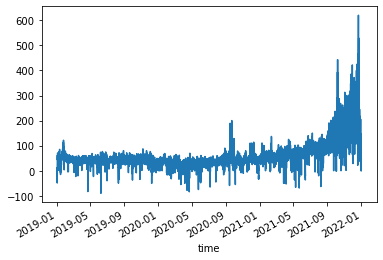

In [74]:
prices_raw_df.plot()

In [75]:
prices_raw_df.

SyntaxError: invalid syntax (1604385606.py, line 1)

### Check distribution

In [ ]:
# plot the results
ax = prices_raw_df.plot(figsize=(15, 6))
ax.set_ylabel('Day-Ahead market clearing prices in €/MWh', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Day-Ahead Auction Electricity Prices for the German Bidding Zone', fontsize=14)
ax.set_ylim((-100, 500));

In [ ]:
prices_raw_df = prices_raw_df[prices_raw_df.index < '2021-03']

In [ ]:
prices_raw_df/24/360

In [ ]:
prices_raw_df.shape

In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
prices_raw_df.hist(bins=50, ax=ax)
ax.set_title('Distribution of Day-Ahead electricity prices for modelisation v0', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Price in €/MWh', fontsize=14);

In [ ]:
prices_df = pd.DataFrame(prices_raw_df, columns=['value']).rename({'value':'price'}, axis=1)

In [ ]:
prices_df.describe()

### Scaling

In [ ]:
scaler = MinMaxScaler()
prices_df['price'] = scaler.fit_transform(prices_df['price'].values.reshape(-1, 1))

### Lag creation

In [76]:
#7 days
lags = 168
for l in range(1, lags+1):
    prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)

In [77]:
prices_df = prices_df.dropna()

In [78]:
# create feature and label dataframes
prelim_features = prices_df.drop('price', axis=1)
prelim_labels = pd.DataFrame(prices_df['price'])

In [79]:
# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['price'].shift(-i)
prelim_labels.drop('price', axis=1, inplace=True)

In [80]:
# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

In [81]:
n_split = int(len(features)*0.90)
features_train = features[:n_split]
features_test = features[n_split:]
labels_train = labels[:n_split]

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

In [82]:
# np ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

features_train.shape, labels_train.shape

((697, 168, 1), (697, 24))

### Naive modelisation

In [83]:
test_raw = prices_raw_df[:n_split]

In [84]:
test_raw = test_raw.dropna()

In [85]:
# calculate benchmarks for test set and save them to dataframe
benchmark_results = pd.DataFrame(index=test_raw.index)

benchmark_results['last_23h'] = prices_raw_df.shift(23)
benchmark_results['last_day'] = prices_raw_df.shift(24)
benchmark_results['previous_7_days'] = prices_raw_df.shift(24*7)
benchmark_results['last_5_days_average'] = pd.concat([prices_raw_df.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)

In [86]:
#prices_raw_df[:168].plot()

In [87]:
benchmark_results = benchmark_results.dropna()

In [88]:
true = test_raw[test_raw.index.isin(benchmark_results.index)]

In [89]:
benchmark_results.shape, true.shape

((529, 4), (529,))

In [90]:
n_start = 24*5
for col in benchmark_results.columns:
    #pred = benchmark_results[col].as_matrix()
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=benchmark_results[col][n_start:], y_true=true[n_start:]))

MAE of last_23h benchmark model:  14.291491442542787
MAE of last_day benchmark model:  13.969951100244499
MAE of previous_7_days benchmark model:  21.430415647921762
MAE of last_5_days_average benchmark model:  15.255103911980441


### LSTM

In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.1, random_state=7)

In [92]:
X_train.shape

(627, 168, 1)

In [93]:
def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, 
                           batch_size, epochs, verbose=0):
    
    """Fit model to training data. Use best performant on validation data to predict for the test set. 
    Evaluate on the test set and return results as dataframes"""
    
    # train model, save best keep best performer on validation set
    #checkpoint = ModelCheckpoint('./models/' + filename, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                     verbose=verbose, batch_size=batch_size, epochs=epochs)
    
    # load best model
    #best = load_model('./models/' + filename)
    
    return model

In [94]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

False
False


In [95]:
X_train.shape

(627, 168, 1)

In [96]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7, 64)             1600      
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 24)                792       
Total params: 14,808
Trainable params: 14,808
Non-trainable params: 0
_________________________________________________________________


In [100]:
# train the model and calculate the performance on the test set
model = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid,32, 50, 
                                       verbose=1)

Epoch 1/50
20/20 [==============================] - 2s 22ms/step - loss: 0.1616 - val_loss: 0.1067
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0609 - val_loss: 0.0229
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0039
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 11/50
20/20 

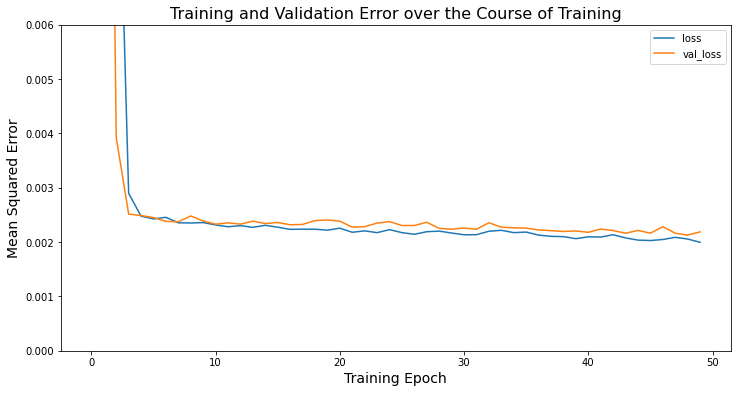

In [101]:
f, ax = plt.subplots()
pd.DataFrame(model.history.history).plot(figsize=(12, 6), ax=ax)
ax.set_ylim([0, 0.006])
ax.set_title('Training and Validation Error over the Course of Training', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_xlabel('Training Epoch', fontsize=14);

## Model save

### Prediction

In [102]:
# predict for test set
pred = model.predict(features_test)

In [103]:
features_test.shape

(78, 168, 1)

In [104]:
pred.shape

(78, 24)

In [105]:
labels_test = labels[n_split:]

In [106]:
# transform back to original data scale
pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))
y_test = scaler.inverse_transform(labels_test.to_numpy().flatten().reshape(-1,1))

In [107]:
results = pd.DataFrame({'prediction':pred.flatten(), 'true values':y_test.flatten()})

In [108]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']))

MAE:  12.356784520383574


In [109]:
len(labels_test.index.month)

78

In [110]:
np.repeat(labels_test.index, 24)

DatetimeIndex(['2020-12-12', '2020-12-12', '2020-12-12', '2020-12-12',
               '2020-12-12', '2020-12-12', '2020-12-12', '2020-12-12',
               '2020-12-12', '2020-12-12',
               ...
               '2021-02-28', '2021-02-28', '2021-02-28', '2021-02-28',
               '2021-02-28', '2021-02-28', '2021-02-28', '2021-02-28',
               '2021-02-28', '2021-02-28'],
              dtype='datetime64[ns]', name='time', length=1872, freq=None)

Text(0.5, 1.0, 'Long Term Predictive Performance')

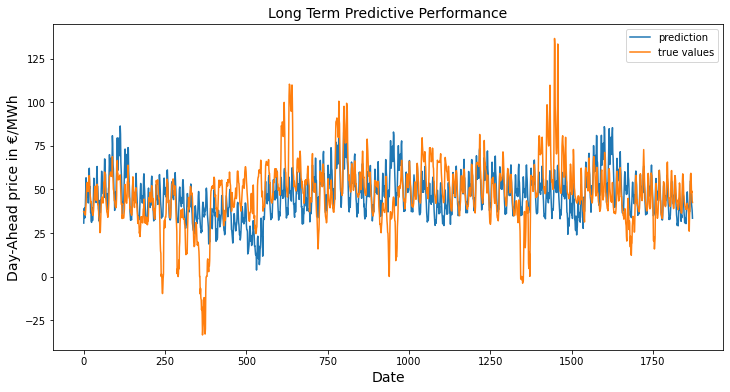

In [111]:
f, ax = plt.subplots(figsize=(12, 6))
results.plot(ax=ax)
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term Predictive Performance', fontsize=14)

In [112]:
labels_test.index

DatetimeIndex(['2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15',
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-19',
               '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
               '2020-12-28', '2020-12-29', '2020-12-30', '2021-01-01',
               '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25',
               '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29',
               '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02',
               '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06',
      

In [113]:
n_random = np.random.randint(0, len(results))

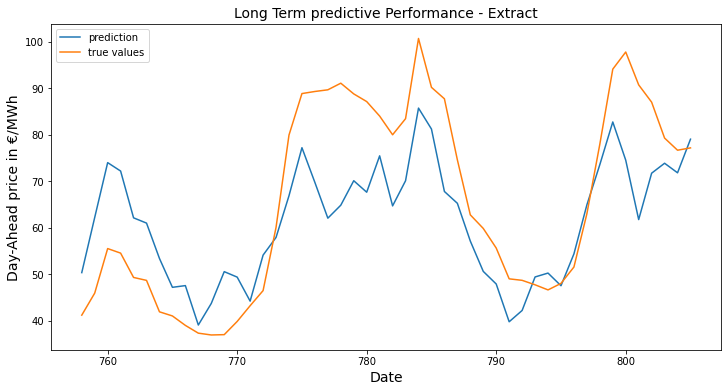

In [114]:
f, ax = plt.subplots(figsize=(12, 6))
n_window = 48
results[n_random:n_random+n_window].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term predictive Performance - Extract', fontsize=14);

### Comparaison with ARIMA

* Compare march

In [81]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)